In [4]:
from pathlib import Path
import pandas as pd
import numpy as np

# All project files (outputs etc.) will be stored here
OUT = Path("/content/data")
OUT.mkdir(exist_ok=True)
print("Output folder created at:", OUT)

Output folder created at: /content/data


In [5]:
cust = pd.read_csv("/content/customers.csv")
usage = pd.read_csv("/content/usage_data.csv")
comp  = pd.read_csv("/content/complaints.csv", parse_dates=["created_at"])
bill  = pd.read_csv("/content/billing.csv")

# Basic cleaning
cust["region"] = cust["region"].str.title().str.strip()
cust["plan_type"] = cust["plan_type"].str.title().str.strip()

for col in ["data_used_gb", "calls_made", "revenue_inr"]:
    usage[col] = usage[col].fillna(usage[col].median())

bill["monthly_charges"] = bill["monthly_charges"].fillna(bill["monthly_charges"].median())
bill["tenure"] = bill["tenure"].fillna(bill["tenure"].median())

comp["status"] = comp["status"].fillna("Resolved")
comp["category"] = comp["category"].fillna("General")

bill["churn_flag"] = (bill["churn"].str.lower() == "yes").astype(int)


In [6]:
# Aggregate complaints
complaint_agg = (
    comp.groupby("customer_id")
    .agg(
        complaints_total=("category", "count"),
        complaints_open=("status", lambda s: (s.str.lower() == "open").sum())
    )
    .reset_index()
)

# Merge all datasets
df = (
    cust.merge(usage, on="customer_id", how="left")
    .merge(complaint_agg, on="customer_id", how="left")
    .merge(bill, on="customer_id", how="left")
)

df[["complaints_total", "complaints_open"]] = (
    df[["complaints_total", "complaints_open"]].fillna(0).astype(int)
)

# Save cleaned master dataset
df.to_csv(OUT / "telecom_master.csv", index=False)
print("✅ Saved:", OUT / "telecom_master.csv")

✅ Saved: /content/data/telecom_master.csv


Churn rate: 0.5


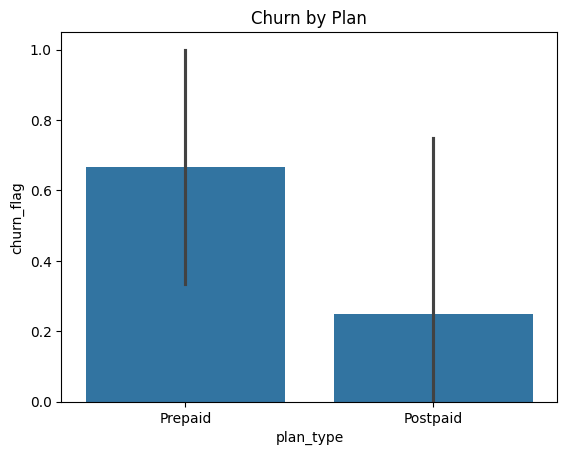

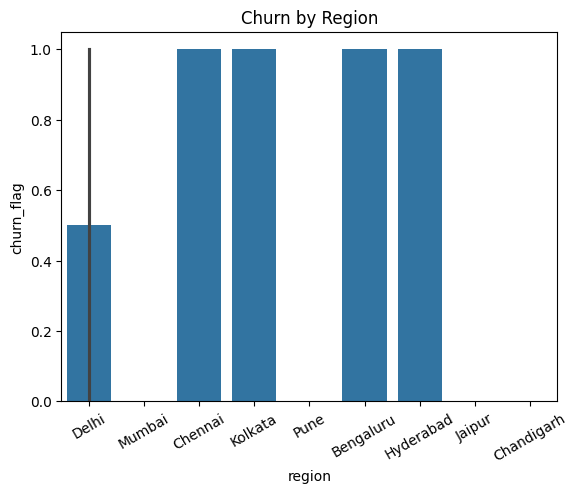

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Churn rate:", round(df["churn_flag"].mean(), 3))

sns.barplot(x="plan_type", y="churn_flag", data=df)
plt.title("Churn by Plan")
plt.show()

sns.barplot(x="region", y="churn_flag", data=df)
plt.title("Churn by Region")
plt.xticks(rotation=30)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, json

# Reload cleaned data
df = pd.read_csv(OUT / "telecom_master.csv")

features = [
    "tenure","monthly_charges","data_used_gb","calls_made","revenue_inr",
    "complaints_total","complaints_open",
    "contract_type","plan_type","region"
]
target = "churn_flag"

X = df[features].copy()
y = df[target].copy()

cat_cols = ["contract_type","plan_type","region"]
num_cols = [c for c in X.columns if c not in cat_cols]

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

logit = Pipeline([
    ("prep", pre),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

tree = Pipeline([
    ("prep", pre),
    ("clf", DecisionTreeClassifier(max_depth=6, class_weight="balanced", random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

logit.fit(X_train, y_train)
tree.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure', 'monthly_charges',
                                                   'data_used_gb', 'calls_made',
                                                   'revenue_inr',
                                                   'complaints_total',
                                                   'complaints_open']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['contract_type', 'plan_type',
                                                   'region'])])),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                                        random_state=42))])

Logistic -> Acc:1.000  Prec:1.000  Rec:1.000  F1:1.000


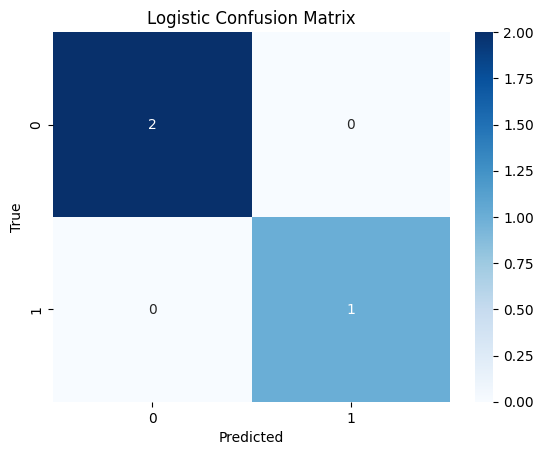

DecisionTree -> Acc:1.000  Prec:1.000  Rec:1.000  F1:1.000


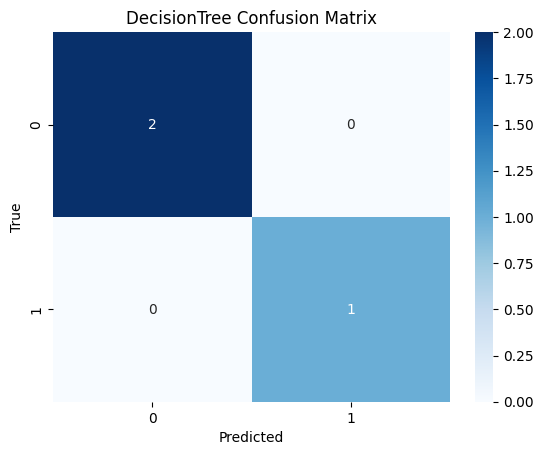

✅ Metrics saved at: /content/data/model_metrics.json
✅ Best model saved at: /content/data/model.pkl
✅ Predictions saved at: /content/data/predictions.csv


In [11]:
 def evaluate(name, model):
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary")
    print(f"{name} -> Acc:{acc:.3f}  Prec:{p:.3f}  Rec:{r:.3f}  F1:{f1:.3f}")

    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    return acc, p, r, f1

metrics = {}
for nm, mdl in [("Logistic", logit), ("DecisionTree", tree)]:
    acc, p, r, f1 = evaluate(nm, mdl)
    metrics[nm] = dict(accuracy=acc, precision=p, recall=r, f1=f1)

# Save metrics
with open(OUT / "model_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Metrics saved at:", OUT / "model_metrics.json")
best = logit if metrics["Logistic"]["f1"] >= metrics["DecisionTree"]["f1"] else tree
joblib.dump(best, OUT / "model.pkl")
print("✅ Best model saved at:", OUT / "model.pkl")

df_pred = df.copy()
df_pred["churn_prob"] = best.predict_proba(X)[:, 1]
df_pred["churn_pred"] = (df_pred["churn_prob"] >= 0.5).astype(int)
df_pred.to_csv(OUT / "predictions.csv", index=False)
print("✅ Predictions saved at:", OUT / "predictions.csv")